# 🗺️ NYC Yellow Taxi ETA Modeling (2023–2024)

# Table of Contents

- [🎯 Problem Statement](#problem-statement)
- [🧹 Data Processing (Handled via dbt)](#data-processing-handled-via-dbt)
  - [🪙 Bronze Layer – Raw Data Ingestion](#bronze-layer-raw-data-ingestion)
    - [NYC Yellow Taxi Trip Data ](#nyc-yellow-taxi-trip-data)
    - [NYC Historical Weather Data ](#nyc-historical-weather-data)
  - [🧪 Silver Layer Data Cleaning and Zone Enrichment](#silver-layer-data-cleaning-and-zone-enrichment)
    - [🔍 Core Objectives](#core-objectives)
    - [🧹 Cleaning Rules Applied](#cleaning-rules-applied)
    - [📍 Spatial Enrichment](#spatial-enrichment)
  - [🧠 Feature Store Layer](#feature-store-layer)
    - [🌦 `weather_features_per_hour`](#weather_features_per_hour)
    - [📊 `zone_avg_12mo`](#zone_avg_12mo)
    - [🧬 `main_trip_features`](#main_trip_features)
- [🔁 Modeling: Predicting Trip Duration (ETA)](#modeling-predicting-trip-duration-eta)
  - [🎯 Target](#target)
  - [🛠 Features include](#features-include)
  - [🧠 Modeling Strategy and Design Choices](#modeling-strategy-and-design-choices)
    - [✅ Why XGBoost](#why-xgboost)
    - [🧬 Why These Features](#why-these-features)
    - [🧮 Why MAE as Primary Metric](#why-mae-as-primary-metric)
    - [⚙️ Why Minimal Data Processing](#why-minimal-data-processing)
    - [🗓 Why Train on 3 Months](#why-train-on-3-months)
    - [🔧 How We Tuned the Model](#how-we-tuned-the-model)
  - [📈 Model Tuning Strategy](#model-tuning-strategy)
    - [🌀 Tuning details](#tuning-details)
    - [🧪 Comparison of Parameter Combos](#comparison-of-parameter-combos)
  - [🛠 Model Training & Evaluation Pipeline](#model-training--evaluation-pipeline)
  - [📈 Metric Trends Interpretation](#metric-trends-interpretation)
    - [📌 Notable Exceptions](#notable-exceptions)
- [📦 Project Summary & Next Steps](#project-summary--next-steps)
  - [🔭 Future Extensions](#future-extensions)


In [2]:
from utilities.spark_utils import get_spark_session
from utilities.xgb_utils import run_and_log_single_month
from utilities.xgb_utils import load_mae_eval_summary




##  Problem Statement



This notebook builds a Spark-based ETA prediction model for NYC Yellow Taxi rides using 2023–2024 data. We address:

- Real-world ETA prediction under traffic volatility
- Model breakdowns during extreme events (e.g., UN week, holidays)
- Scalable ML workflow with Spark + MLflow

In [3]:
spark = get_spark_session()

25/07/02 16:54:07 WARN Utils: Your hostname, Duys-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.30.28.145 instead (on interface en0)
25/07/02 16:54:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/07/02 16:54:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Spark session initialized (v3.4.2)


##  Data Processing (Handled via dbt)




### Bronze Layer Raw Data Ingestion



Our pipeline ingests and unifies raw data from two external sources:

---

#### NYC Yellow Taxi Trip Data

Source: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page.
We use a Jinja macro to dynamically read monthly `.parquet` files into Spark via dbt. This macro ensures:
- Explicit column casting to consistent types
- Easy extension across years/months
- Single unified SQL `SELECT ... UNION ALL` structure

Each file follows the format:  
`yellow_tripdata_YYYY-MM.parquet`  
and is cast into schema-aligned types like `VendorID`, `pickup_datetime`, `fare_amount`, etc.

---

#### NYC Historical Weather Data 

Source: Open-Meteo Archive API (https://open-meteo.com/) — used to download hourly weather data for each borough.
Weather files are stored by? **borough, year, and month**.  
We use a macro to load each borough’s monthly `.parquet` into Spark and union them all together.
Each file follows the format:  
`/path/to/bronze_weather/Manhattan_2023_01.parquet`  
and includes hourly weather features like:
- `temperature`
- `precipitation`
- `windspeed`
- `cloudcover`
- `snow`

---

These raw sources feed into the **Silver Layer** for cleaning and normalization before we engineer ML features in the Feature Store.



### Silver Layer Data Cleaning and Zone Enrichment

The Silver Layer performs critical data validation, enrichment, and filtering on top of the raw Bronze tables.

---

#### Core Objectives:
- Remove corrupted, outlier, or invalid data
- Enrich trips with location metadata (zones, boroughs, service zones)
- Compute derived features like trip duration
- Prepare clean records for downstream ML feature engineering

---

#### Cleaning Rules Applied:

- **Passenger Count**:
  - Must be < 7
  - Null values dropped

- **Trip Distance**:
  - Must be > 0 and < 100 miles
  - Removes extreme or zero-distance rides

- **Fare Logic**:
  - `fare_amount` between 0 and 200
  - Tip capped at 500, tolls < 50
  - Valid `mta_tax`, `surcharge`, and `payment_type` values enforced

- **Temporal Logic**:
  - `pickup_datetime` between 2023–2024
  - `dropoff > pickup`, duration between 1–60 minutes
  - Derived column: `trip_duration_seconds`

- **Corruption Checks**:
  - Negative or extreme payment values removed

---

#### Spatial Enrichment:

- Joined with official NYC **Taxi Zone Lookup** table
  - Adds `PU_Zone`, `PU_Borough`, `DO_Zone`, `DO_Borough`, etc.
- These attributes are key for **zone-pair level modeling** and clustering in later stages

---

This layer ensures that only valid, interpretable trips move forward to the Feature Store for ML training.



### Feature Store Layer

Our Feature Store consists of three structured dbt models that transform cleaned Silver Layer data into rich, ML-ready features. These features capture weather conditions, location-level aggregates, and temporal patterns.

---

#### weather_features_per_hour
Enriches each taxi trip with weather conditions **at the hour and borough level**, including:

- Raw weather data: `temperature`, `precipitation`, `snow`, `windspeed`, `cloudcover`
- Binary flags: `is_heavyrain`, `is_snowfall`, `is_cold`, `is_highwind`
- Composite condition: `is_bad_weather`
- Labeled condition: `weather_condition` (`clear`, `heavy_rain`, `snowfall`, etc.)

> All weather data comes from archived hourly readings by borough across 2023–2024.

---

#### zone_avg_12mo
Generates **rolling monthly aggregates** at the `PU_Zone → DO_Zone` level:

- Aggregates for 3, 6, 9, and 12 months
- Metrics: `trip_count`, `avg_fare`, `avg_distance`, `avg_duration`, `avg_speed`

> This serves as the **baseline model input** — allowing us to model ETA residuals (`actual - average`).

---

#### main_trip_features
Final model table built by joining:
- The cleaned taxi trips
- Time-based signals from a `dim_date` table
- Zone-level rolling averages
- Borough-hour-level weather features

Key derived features:
- Temporal: `pickup_hour`, `is_rush_hour`, `sin/cos transforms` for hour/month/day
- Spatial: `is_same_borough`, `is_airport_trip`, `zone clusters`
- Fare & trip stats: `tip_pct`, `total_amount`, `duration_minutes`
- External: `is_holiday`, `is_bad_weather`, `weather_condition`, etc.

> This is the **input table used by our ML pipeline** in this notebook.

---

Together, these three models enable modular, explainable, and reproducible ML feature generation using `dbt` on Spark — fully batchable and trackable across time.

---

## Modeling: Predicting Trip Duration (ETA)

With all features prepared via the Feature Store, we now build a machine learning model to predict **trip duration in minutes**.

---

### Target:
- `trip_duration_minutes` (direct prediction of trip ETA)

### Features include:
- Temporal: hour of day, day of week, month (with sin/cos transforms)
- Spatial: pickup/dropoff zone, borough, airport flags
- Weather: temperature, precipitation, windspeed, cloudcover
- Fare context: tip percentage, total amount
- Behavioral: rush hour flags, store-and-forward, vendor ID
- Historical: zone-pair rolling averages (3–12 month)

---

We train the model using **XGBoost on Spark** (`SparkXGBoostRegressor`) and evaluate it across months to ensure stable performance and generalization.


### Modeling Strategy and Design Choices

This section outlines the reasoning behind our modeling architecture and configuration.

---

#### Why XGBoost?

We use `SparkXGBoostRegressor` for the following reasons:
- **Tree-based model**: Handles non-linear relationships without requiring feature scaling or standardization.
- **Robust to skewed distributions**: Effective for trip duration, which has a long-tailed pattern.
- **Native support in Spark**: Can be trained in parallel at scale across full 2023–2024 data.
- **Built-in regularization**: Prevents overfitting on noisy or high-cardinality categorical features.

---

#### Why These Features?

Our feature set includes:
- **Temporal**: hour of day, day of week, month (sin/cos encoded)
- **Spatial**: pickup/dropoff zones, boroughs, airport flags
- **Weather**: precipitation, windspeed, cloudcover, temperature
- **Contextual**: vendor ID, rush hour, fare components
- **Historical averages**: 3 and 12 month rolling metrics by zone-pair,capturing both recent and long term effectiveness

These were chosen based on domain intuition and exploratory analysis that showed time, weather, and zone-level traffic patterns significantly affect ETA.

---

#### Why MAE as Primary Metric?

We report RMSE, MAE, and R² — but prioritize **MAE** for the following reasons:
- **Interpretability**: MAE is in minutes, and directly answers “how far off are we, on average?”
- **Robustness**: Unlike RMSE, MAE is less sensitive to extreme outliers (e.g. stalled rides, airport delays).
- **Business relevance**: In ETA modeling, consistent average error is often more actionable than minimizing rare but large mistakes.
- **Focus on the majority**: MAE better reflects the experience of the bulk of rides — our priority is modeling the central 90–95% of trips accurately, not overfitting to long-tailed outliers. 

---

#### Why Minimal Data Processing?

Since we use **tree-based models**, we intentionally avoid:
- Scaling numeric features
- One-hot encoding
- Imputation (we drop rows with nulls in dbt)

XGBoost handles raw feature distributions well, especially when the upstream data is cleaned and structured via dbt.

---

#### Why Train on 3 Months?

We train the model on **3 months of data at a time** to strike the right balance between **recency** and **robustness**:

- **Recency**: Captures seasonal shifts in traffic, rider behavior, and weather  
- **Volume**: Millions of rows over 3 months provide strong variety and statistical power  
- **Stability**: Long enough to generalize across zone-pairs, short enough to avoid concept drift  

> We tested training on longer windows (6, 9, 12 months), but observed **minimal gains in MAE/RMSE** while significantly increasing training time.  
> To keep the pipeline fast and maintain operational freshness, we stick with 3-month rolling windows.

#### How We Tuned the Model

We manually tested multiple XGBoost parameter combinations to optimize MAE performance while keeping model complexity manageable. Each configuration was trained using the same 3-month window and feature set, then evaluated on the following month.

The tuning focused on:
- **Tree depth (`max_depth`)** – to control model complexity  
- **Learning rate (`eta`)** – to balance speed vs precision  
- **Subsampling (`subsample`, `colsample_bytree`)** – to improve generalization  
- **Number of rounds (`num_round`)** – to ensure convergence without overfitting

Results are shown below. We chose **Combo D** for its best-in-class MAE and efficient training speed.

👇 See next section: `📈 Model Tuning Strategy` for full comparison and rationale.

---

### Model Tuning Strategy

We conducted hyperparameter tuning using a structured rolling split strategy.

---

#### <a id='toc1_4_4_1_'></a>[🌀 Tuning details](#toc0_)

For each test month (e.g., January 2025), we performed the following:

- **Train**: The 2 months prior to the test month  
- **Validation**: The month directly before the test month  
- **Test**: The held-out test month

This ensures our model is tuned on past data only — mimicking how it would be deployed in production.

We evaluated several parameter combinations and compared their MAE, RMSE, and R² on the validation month.  
Once the best-performing configuration was found (Combo D), we compared it to the **base untuned model** and observed a **marginal but consistent improvement in MAE and R²**.

> Because the improvement was meaningful and stable across months, we **applied the same best-tuned configuration** across all monthly test sets to avoid overfitting and keep the pipeline simple and reproducible.

---

#### Comparison of Parameter Combos

| Combo | Description | max_depth | eta  | num_round | subsample | colsample_bytree | min_child_weight | MAE    | RMSE   | R²     |
|-------|-------------|-----------|------|-----------|-----------|------------------|------------------|--------|--------|--------|
| A     | Shallow + high learning rate | 4         | 0.3  | 50        | –         | –                | –                | 3.8125 | 5.3954 | 0.7571 |
| B     | Base config (moderate depth) | 6         | 0.1  | 100       | –         | –                | –                | 3.7588 | 5.3280 | 0.7631 |
| C     | Deep trees + slow learn rate | 8         | 0.05 | 150       | –         | –                | –                | 3.7709 | 5.3483 | 0.7613 |
| **D** | Tuned depth + sampling | 6         | 0.1  | 100       | 0.8       | 0.8              | –                | **3.7566** | **5.3288** | **0.7630** |
| E     | Add min_child_weight (light reg) | 6         | 0.1  | 100       | –         | –                | 5                | 3.7612 | 5.3383 | 0.7622 |
| F     | Deep + full regularization | 8         | 0.05 | 150       | 0.7       | 0.7              | 10               | 3.7569 | 5.3397 | 0.7621 |

> **Combo D** showed the best trade-off between performance and generalization.  
It became our **default configuration** for all monthly evaluations.


### Model Training & Evaluation Pipeline

In [ ]:
from datetime import datetime
for month in range(1, 13):  # Jan to Dec 2024
    run_and_log_single_month(
        df=spark.sql(""" SELECT * FROM feature_store.main_trip_features"""),
        test_month=datetime(2024, month, 1),
        run_name_prefix="xgb_mae"
    )

In [ ]:
summary_df = load_mae_eval_summary()
summary_df.head(12)


,test_month,rmse,mae,r2
0,2024-01,5.013551,3.653671,0.748277
1,2024-02,4.760449,3.276784,0.778543
2,2024-03,4.970135,3.389798,0.780533
3,2024-04,5.013753,3.454932,0.780297
4,2024-05,5.368884,3.694158,0.764656
5,2024-06,5.152111,3.584817,0.778739
6,2024-07,4.960344,3.517042,0.796049
7,2024-08,4.823490,3.367411,0.808438
8,2024-09,6.153744,4.125202,0.708761
9,2024-10,5.716704,3.912946,0.740043


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

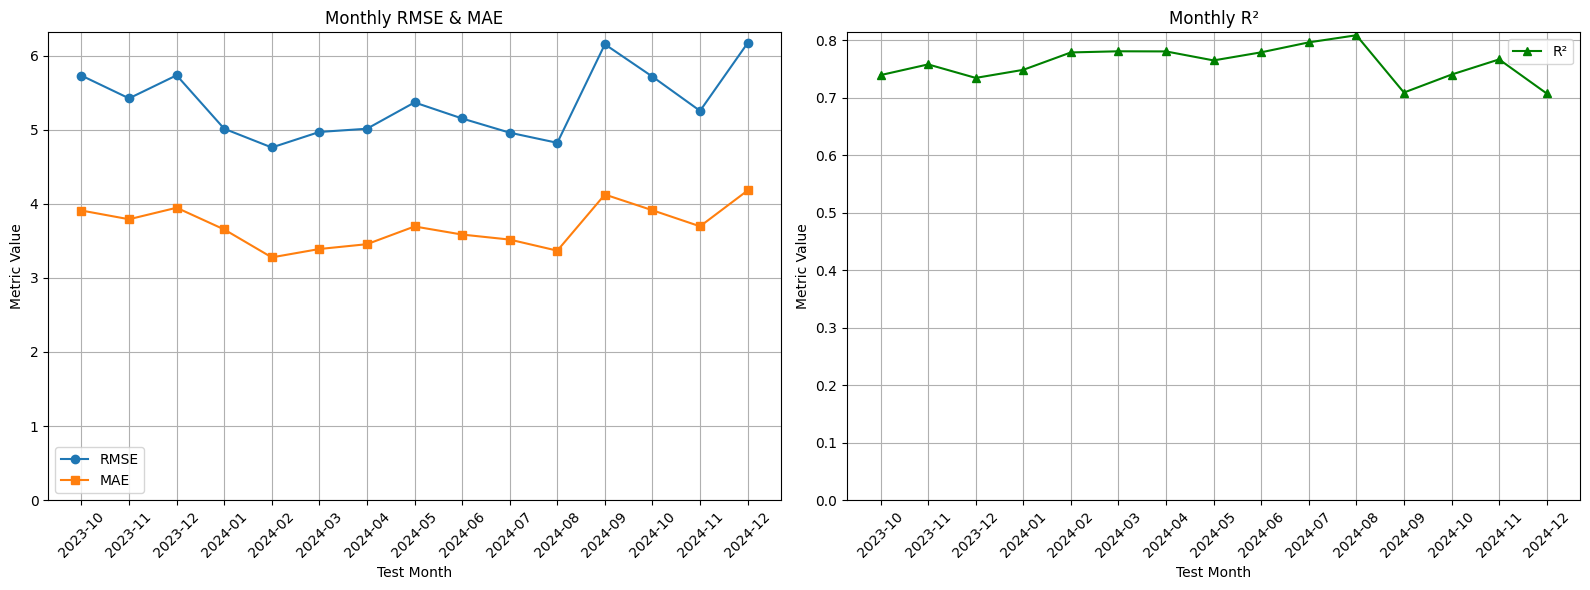

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# --- First plot: RMSE & MAE ---
axes[0].plot(summary_df["test_month"], summary_df["rmse"], marker='o', label='RMSE')
axes[0].plot(summary_df["test_month"], summary_df["mae"], marker='s', label='MAE')
axes[0].set_title("Monthly RMSE & MAE")
axes[0].set_xlabel("Test Month")
axes[0].set_ylabel("Metric Value")
axes[0].set_ylim(bottom=0)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True)
axes[0].legend()

# --- Second plot: R² ---
axes[1].plot(summary_df["test_month"], summary_df["r2"], marker='^', color='green', label='R²')
axes[1].set_title("Monthly R²")
axes[1].set_xlabel("Test Month")
axes[1].set_ylabel("Metric Value")
axes[1].set_ylim(bottom=0)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

### Metric Trends Interpretation
Overall, the evaluation metrics across all test months show strong and reliable performance:

RMSE and MAE trend smoothly from January to August 2024, demonstrating consistent model accuracy across typical monthly variations in trip patterns.

MAE remains tightly bounded between 3.27 and 3.69 minutes for most months, affirming the model’s ability to minimize average error in a real-world, high-variance setting.

R² scores stay high—ranging from 0.75 to 0.81—reflecting solid explanatory power of the feature set.

#### Notable Exceptions:

September and December display spikes in RMSE and MAE.

In **September**, we observe notable error spikes concentrated on a **few specific days**:

| Date        | RMSE  | MAE   |
|-------------|--------|--------|
| 2024-09-24  | 8.03  | 5.21  |
| 2024-09-23  | 7.78  | 5.04  |
| 2024-09-25  | 7.75  | 5.02  |
| 2024-09-26  | 7.52  | 4.97  |
| 2024-09-21  | 7.23  | 4.80  |

These days **stand out from surrounding weekdays**, where typical RMSE values ranged between 5.2–6.2. The concentration of volatility is limited to about **5–6 peak anomaly days**, indicating **a localized disruption** rather than a full-month breakdown.
This period coincides with the **UN General Assembly** in NYC (September 19–26, 2024), a well-documented source of traffic lockdowns, road closures, and major rerouting. The spike aligns with historical data and news reports of **heavy congestion**, which would distort trip patterns and reduce our model's generalizability.


**December** is widely known as one of the most **chaotic and high-variance months** in NYC due to:
- Holiday travel surges
- Increased tourism and shopping traffic
- Frequent schedule deviations (office parties, school breaks, etc.)

These real-world complexities likely introduced **non-repeating anomalies** that are hard to generalize across years. While no conclusive root cause was found, the **seasonal volatility hypothesis remains plausible** and aligned with prior industry observations.



## Project Summary & Next Steps

This notebook demonstrated an end-to-end ETA prediction pipeline using NYC Yellow Taxi data with Spark and dbt. We:
- Ingested and cleaned raw data
- Engineered ML-ready features
- Tuned and evaluated an XGBoost model over 12 months
- Investigated performance anomalies in September and December

### Future Extensions:
- December specific features, YoY training data inclusion
- Routing Engine?
